# Augurpy

This is a short tutorial demonstrating augurpy, the python implementation of the [Augur R package](https://github.com/neurorestore/Augur) based on Skinnider, M.A., Squair, J.W., Kathe, C. et al. [Cell type prioritization in single-cell data](https://doi.org/10.1038/s41587-020-0605-1). Nat Biotechnol 39, 30–34 (2021). 


Augurpy aims to rank or prioritize cell types according to the their response to experimental perturbations given high dimensional single-cell sequencing data. The basic idea is that in the space of molecular measurements cells reacting heavily to induced perturbations are more easily seperated into perturbed and unperturbed than cell types with little or no response. This seperability is quantified by measuring how well experimental labels (eg. treatment and control) can be predicted within each cell type. Augurpy trains a machine learning model predicting experimental labels for each cell type in multiple cross validation runs and then prioritizes cell type response according to metric scores measuring the accuracy of the model. For categorical data the area under the curve is the default metric and for numerical data the concordance correlation coefficient is used as a proxy for how accurate the model is which in turn approximates perturbation response. 

The following tutorial runs through a simple analysis with augurpy using a simulated dataset. This dataset consists of 600 cells, distributed evenly between three populations (cell types A, B, and C). Each of these cell types has approximately half of its cells in one of two conditions, treatment and control. The cell types also have different numbers of genes differentially expressed (DE) in response to the treatment. Cell type A has approximately 5% of genes DE in response to the treatment, while cell type B has 25% of its genes DE and cell type C has 50% of genes DE. 

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
import pertpy as pt

Unable to contact PyPI to check for the latest pertpy version. Do you have an internet 
connection?

First we import the data that we want to work with. This can either be an anndata object, a dataframe containing cell type labels as well as conditions for each cell or data contained in a dataframe with corresponding meta data containing cell type labels and conditions. Here we use scanpy to read the simulated sample anndata set contained in augurpy. Then we load this data into an anndata object adding dummie variables of labels and renaming cell type and label observation columns to `cell_type` and `label`.

In [3]:
# import data
adata = pt.data.sc_sim_augur()


loaded_data = pt.tl.augurpy.read_load.load(adata)

In [4]:
loaded_data

AnnData object with n_obs × n_vars = 600 × 15697
    obs: 'label', 'cell_type', 'y_'
    var: 'name'

Next we choose the estimator used to measure how predictable the perturbation labels for each cell type in the dataset are. Choose `random_forest_classifier` or `logistic_regression_classifier` for categorical data and `random_forest_regressor` for numerical data. Additional parameters can be added throught the `Params` class.

In [5]:
random_forest = pt.tl.augurpy.estimator.create_estimator("random_forest_classifier")

Then we run augurpy with the function `predict` and look at the results. 

In [6]:
h_adata, h_results = pt.tl.augurpy.evaluate.predict(loaded_data, random_forest, subsample_size=20)

print(h_results["summary_metrics"])

Output()

Unable to contact PyPI to check for the latest pertpy version. Do you have an 
internet connection?
Unable to contact PyPI to check for the latest pertpy version. Do you have an 
internet connection?
Unable to contact PyPI to check for the latest pertpy version. Do you have an 
internet connection?
Unable to contact PyPI to check for the latest pertpy version. Do you have an 
internet connection?


                  CellTypeA  CellTypeB  CellTypeC
mean_augur_score   0.598299   0.867948   0.918435
mean_auc           0.598299   0.867948   0.918435
mean_accuracy      0.542674   0.735971   0.783040
mean_precision     0.539211   0.782898   0.790340
mean_f1            0.419785   0.697024   0.795674
mean_recall        0.418889   0.704921   0.855873


The default way to select features is based on `scanpy.pp.highly_variable_genes`. The results are shown above. In addition there is also the option of selecting features with `select_variance` activated by setting `select_variance_features=True`, an implementation that is very close to the original R Augur implementation.

Set smaller span value in the case of a `segmentation fault` error.

Set larger span in case of svddc or other near singularities error.

Output()

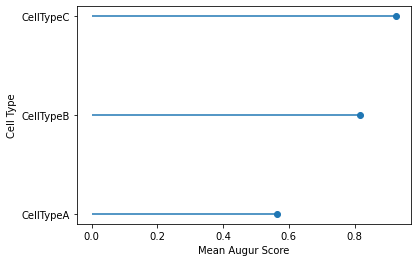

In [7]:
v_adata, v_results = pt.tl.augurpy.evaluate.predict(
    loaded_data, random_forest, subsample_size=20, select_variance_features=True
)

# to visualize the results
lollipop = pt.pl.augurpy.lollipop.lollipop(v_results)

Here we visualize the cell ranking and the corresponding augur scores using `select variance` feature selection in a lollipop plot. In this case the ranking it the same but the values themselves differ between the two methods. 

To compare the two feature selection methods they can be plotted together in a scatterplot. Here you can see that CellTypeB has slightly higher values when using the method `select_highly_variable` compared to `select_variance`, where as CellTypeC has the same augur score.

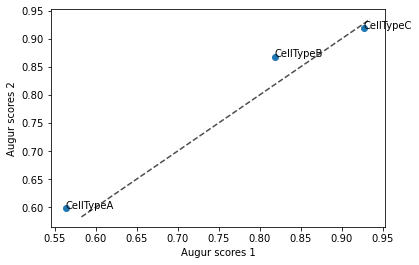

In [8]:
scatter = pt.pl.augurpy.scatterplot.scatterplot(v_results, h_results)

The corresponding `mean_augur_score` is also saved in `result_adata.obs` and can be plotted in a UMAP.

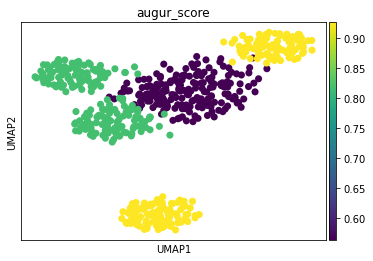

In [9]:
sc.pp.neighbors(adata, use_rep="X")
sc.tl.umap(adata)
sc.pl.umap(adata=v_adata, color="augur_score")

### Feature Importances

The results object also returns feature importances. In the case of a random forest estimator the feature importances built into sci-kit learn were used as feature importances. For the logistic regression the agresti method was used (as in the R library Augur). This means the mean was subtracted from the coefficient values and then divided by the standard deviation. (See [blog post](https://think-lab.github.io/d/205/))

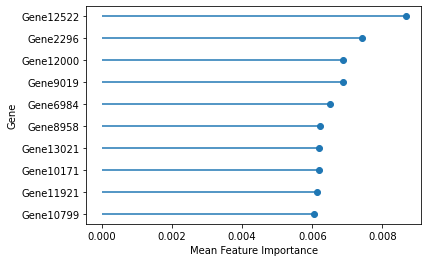

In [10]:
important_features = pt.pl.augurpy.important_features.important_features(v_results)

### Differential Prioritization

Augurpy is also able to perform differential prioritization and executes a permutation test to identify cell types with statistically significant differences in AUC between two different rounds of cell type prioritization (eg. response to drugs A and B, compared to untreated control). 

In the following part, single-cell prefrontal cotrex data from adult mice under cocaine self-administration from  Bhattacherjee A, Djekidel MN, Chen R, Chen W, Tuesta LM, Zhang Y. [Cell type-specific transcriptional programs in mouse prefrontal cortex during adolescence and addiction](https://doi.org/10.1038/s41467-019-12054-3). Nat Commun. 2019 Sep 13. will be used. Adult mice were subject to cocaine self-administration, samples were collected a three time points: Maintance, 48h after cocaine withdrawal and 15 days after cocaine withdrawal.

In the following data, `withdraw_15d_Cocaine` and `withdraw_48h_Cocaine` will be compared with respect to the difference to `Maintenance_Cocaine`. Each variation is run once in default mode and once in permute mode.

In [11]:
# Load data and classifier
bhattacherjee_adata = pt.data.bhattacherjee()
random_forest = pt.tl.augurpy.estimator.create_estimator("random_forest_classifier")

For this we first run Augur on `Maintenance_Cocaine` and `withdraw_15d_Cocaine` in `augur_mode`=`default`  and `augur_mode`=`permute` mode. 

In [12]:
# default
bhattacherjee_15 = pt.tl.augurpy.read_load.load(
    bhattacherjee_adata, condition_label="Maintenance_Cocaine", treatment_label="withdraw_15d_Cocaine"
)

bhattacherjee_adata_15, bhattacherjee_results_15 = pt.tl.augurpy.evaluate.predict(
    bhattacherjee_15, n_threads=1, classifier=random_forest, random_state=None
)

print(bhattacherjee_results_15["summary_metrics"].loc["mean_augur_score"].sort_values(ascending=False))

Filtering samples with Maintenance_Cocaine and withdraw_15d_Cocaine labels.

Output()

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Oligo         0.916088
Astro         0.912823
Microglia     0.907279
OPC           0.900397
Endo          0.780590
Excitatory    0.688617
NF Oligo      0.678730
Inhibitory    0.660023
Name: mean_augur_score, dtype: float64


In [13]:
# permute
bhattacherjee_adata_15_permute, bhattacherjee_results_15_permute = pt.tl.augurpy.evaluate.predict(
    bhattacherjee_15, n_threads=4, augur_mode="permute", classifier=random_forest, n_subsamples=100, random_state=None
)

Output()

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Now lets do the same looking at `Maintenance_Cocaine` and `withdraw_48h_Cocaine`.

In [14]:
# default
bhattacherjee_48 = pt.tl.augurpy.read_load.load(
    bhattacherjee_adata, condition_label="Maintenance_Cocaine", treatment_label="withdraw_48h_Cocaine"
)

bhattacherjee_adata_48, bhattacherjee_results_48 = pt.tl.augurpy.evaluate.predict(
    bhattacherjee_48, n_threads=1, classifier=random_forest, random_state=None
)

print(bhattacherjee_results_48["summary_metrics"].loc["mean_augur_score"].sort_values(ascending=False))

Filtering samples with Maintenance_Cocaine and withdraw_48h_Cocaine labels.

Output()

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Inhibitory    0.675272
Astro         0.664728
OPC           0.628141
Microglia     0.614116
Endo          0.603107
Oligo         0.589728
NF Oligo      0.587596
Excitatory    0.559229
Name: mean_augur_score, dtype: float64


In [15]:
# permute
bhattacherjee_adata_48_permute, bhattacherjee_results_48_permute = pt.tl.augurpy.evaluate.predict(
    bhattacherjee_48, n_threads=4, augur_mode="permute", classifier=random_forest, n_subsamples=100, random_state=None
)

Output()

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Data not normalized. Normalizing now using scanpy log1p normalize.

Skipping NF Oligo cell type - 79 samples is less than min_cells 100.

Lets also take a look at the augur scores of the two versions in a scatterplot. The diagonal line is the identity function. If the values were the same they would be on the line. 

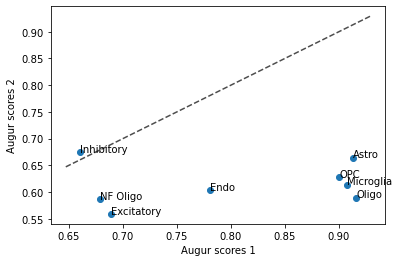

In [16]:
scatter = pt.pl.augurpy.scatterplot.scatterplot(bhattacherjee_results_15, bhattacherjee_results_48)

To figure out which cell type was most affected in comparing `withdraw_48h_Cocaine` and `withdraw_15d_Cocaine` we can run differential prioritization.

In [17]:
pvals = pt.tl.augurpy.differential_prioritization.predict_differential_prioritization(
    augur_results1=bhattacherjee_results_15,
    augur_results2=bhattacherjee_results_48,
    permuted_results1=bhattacherjee_results_15_permute,
    permuted_results2=bhattacherjee_results_48_permute,
)

In [18]:
pvals

,cell_type,mean_augur_score1,mean_augur_score2,delta_augur,b,m,z,pval,padj
0,Microglia,0.907279,0.614116,-0.293163,1000,1000,-20.458239,0.001998,0.002331
1,Inhibitory,0.660023,0.675272,0.015249,1000,1000,2.645889,0.001998,0.002331
2,OPC,0.900397,0.628141,-0.272256,1000,1000,-17.833696,0.001998,0.002331
3,Oligo,0.916088,0.589728,-0.326361,788,1000,-21.920250,0.425574,0.425574
4,Astro,0.912823,0.664728,-0.248095,1000,1000,-15.231971,0.001998,0.002331
5,Excitatory,0.688617,0.559229,-0.129388,1000,1000,-9.034865,0.001998,0.002331
6,Endo,0.780590,0.603107,-0.177483,1000,1000,-10.232838,0.001998,0.002331


The p-value, following the R Augur implementation is calculated using b, the number of times permuted values are larger than original values and m, the number of permutations run. Since b is the same for all cells but OPC, the p-value is the same for these as well.

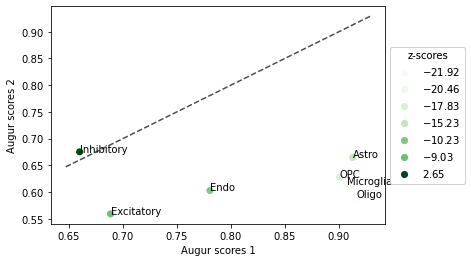

In [19]:
diff = pt.pl.augurpy.differential_prioritization.dp_scatter(pvals)

In this case the cell type Microglia has the lowest p-value, meaning that in comparing the impact of `withdraw_48h_Cocaine` and `withdraw_15d_Cocaine`, this cell type was most perturbed. 